You can find the entry task of the Kiwi.com Machine Learning weekend here: https://github.com/kiwicom/mlweekend

The IP address is 165.227.157.145 and port 8080. An example of API is: http://165.227.157.145:8080/api/do_measurement?x=2

Please send your solution to mlweekend@kiwi.com no later than midnight on Sunday, October 22. We'll send you our evaluation by Tuesday, October 24. The sooner you send your solution, the sooner we'll let you know. 

Since the summer was kind of boring, you applied for a temporary contract on the dark web. It turned out that you’re the only data scientist in the team; the others are mostly hackers doing industrial espionage. Long story short, after some work on their side, they provided you with VPN access to a factory in Kazakhstan. They’ve enabled you to call the endpoint of one of the machines where a secret mathematical formula is hidden. Your goal is to get the formula. Unfortunately, the machine works like a black box — you can just send an x-value to it

/api/do_measurement?x=4 (the IP will be specified in the e-mail)

to measure the y-value within the resulted JSON

{"data": {"y": 188.58938971580736, "x": 4.0}}

It looks like that the machine is just a working prototype, so the readings are a bit fuzzy and it’s probably a good idea to do more measurements to get some reasonable data. Also for some intervals of x, the y-values are missing; feel free to interpolate.

Your task is do the measurements, get the secret formula f where y = f(x) and send it to the organisers (with a graph included). Please use Numpy and attach (or link) all the code you’ve used.

Send your solution to mlweekend@kiwi.com no later than midnight on Sunday, October 22. We'll send you our evaluation by Tuesday, October 24. The sooner you send your solution, the sooner we'll let you know.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import urllib
import tensorflow as tf
from sklearn.linear_model import Lasso, ElasticNet
from sklearn import svm
%matplotlib inline

In [1]:
def get_data(lim = (-5, 5), step = 0.1):
    url = 'http://165.227.157.145:8080/api/do_measurement?x='
    x = np.arange(lim[0], lim[1], step)
    y = np.zeros(len(x), dtype = np.float)
    
    for i in range(len(x)):
        response = urllib.request.urlopen(url + str(x[i])).read()
        data = json.loads(response)
        y[i] = data['data']['y']

    nanmask = np.isnan(y)
    y[nanmask] = np.interp(x[nanmask], x[~nanmask], y[~nanmask])
    return y

In [4]:
lim = (-2.5, 2.5)
step = 0.1
sweeps = 20
x = np.arange(lim[0], lim[1], step)
Y = np.zeros([sweeps, len(x)], dtype = np.float)

for i in range(sweeps):
    Y[i, :] = get_data(lim = lim, step = step)
    
y_mean = np.apply_along_axis(np.mean, 0, Y)

In [8]:
def polygen(p):
    
    def f(x):
        y = 0
        for i in range(len(p)):
            y += p[i] * x ** (len(p) - i - 1)
            
        return y
    
    return f

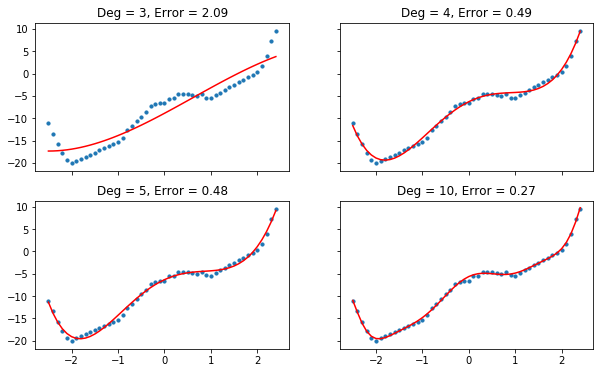

In [9]:
plt.rcParams['figure.figsize'] = (10, 6)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex = 'col', sharey = 'row')

p = np.polyfit(x, y_mean, 3) 
f = polygen(p)
y_pred = np.array(list(map(f, x)))
error = np.mean(np.sqrt((y_pred - y_mean) ** 2))
ax1.scatter(x, y_mean, s = 10)
ax1.plot(x, y_pred, 'r')
ax1.set_title("Deg = 3, Error = " + str(error)[ : 4])

p = np.polyfit(x, y_mean, 4) 
f = polygen(p)
y_pred = np.array(list(map(f, x)))
error = np.mean(np.sqrt((y_pred - y_mean) ** 2))
ax2.scatter(x, y_mean, s = 10)
ax2.plot(x, y_pred, 'r')
ax2.set_title("Deg = 4, Error = " + str(error)[ : 4])

p = np.polyfit(x, y_mean, 5) 
f = polygen(p)
y_pred = np.array(list(map(f, x)))
error = np.mean(np.sqrt((y_pred - y_mean) ** 2))
ax3.scatter(x, y_mean, s = 10)
ax3.plot(x, y_pred, 'r')
ax3.set_title("Deg = 5, Error = " + str(error)[ : 4])

p = np.polyfit(x, y_mean, 10) 
f = polygen(p)
y_pred = np.array(list(map(f, x)))
error = np.mean(np.sqrt((y_pred - y_mean) ** 2))
ax4.scatter(x, y_mean, s = 10)
ax4.plot(x, y_pred, 'r')
ax4.set_title("Deg = 10, Error = " + str(error)[ : 4])

plt.show()

plt.rcParams['figure.figsize'] = (6, 4)

In [72]:
Y1D = Y.reshape(len(Y[0, :]) * sweeps)
X1D = np.tile(x, sweeps)
Y1D = Y1D.reshape(-1, 1)
X1D = X1D.reshape(-1, 1)

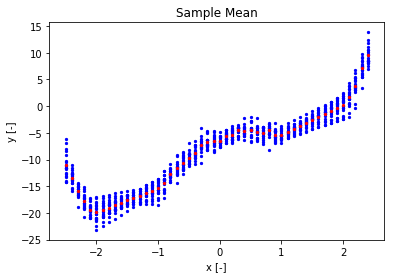

In [64]:
plt.scatter(X1D, Y1D, s = 5, c = 'b')
plt.scatter(x, y_mean, s = 5, c = 'r')
plt.title('Sample Mean')
plt.xlabel('x [-]')
plt.ylabel('y [-]')
plt.show()

In [131]:
feature_columns = [tf.feature_column.numeric_column("x", shape = [1])]

regressor = tf.estimator.DNNRegressor(feature_columns = feature_columns,
                                      hidden_units    = [256, 512, 256])

train_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": X1D},
                                                    y = np.array(Y1D, dtype = np.int),
                                                    num_epochs = None,
                                                    shuffle = True)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": np.array(X1D)},
                                                      num_epochs = 1,
                                                      shuffle = False)

regressor.train(input_fn = train_input_fn, steps = 100)
y_pred = regressor.predict(predict_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Jan\\AppData\\Local\\Temp\\tmp838l2gou', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Jan\AppData\Local\Temp\tmp838l2gou\model.ckpt.
INFO:tensorflow:loss = 14500.8, step = 1
INFO:tensorflow:Saving checkpoints for 100 into C:\Users\Jan\AppData\Local\Temp\tmp838l2gou\model.ckpt.
INFO:tensorflow:Loss for final step: 696.139.


In [144]:
predictions = regressor.predict(predict_input_fn)
y_pred = [val for val in predictions]
y_pred = np.array(list(map(lambda x: x['predictions'][0], y_pred)))

INFO:tensorflow:Restoring parameters from C:\Users\Jan\AppData\Local\Temp\tmp838l2gou\model.ckpt-100


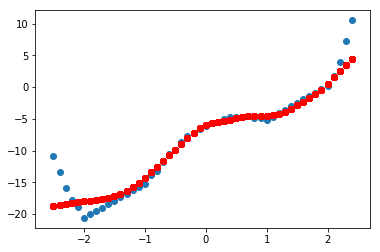

In [145]:
plt.scatter(x, y_mean)
plt.scatter(X1D, y_pred, c = 'r')
plt.show()

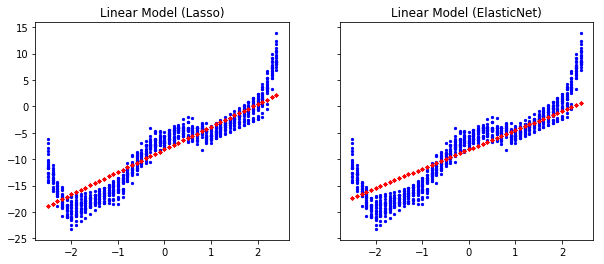

In [115]:
# Lasso
regL = Lasso()
regL.fit(X1D, Y1D)
Y1D_lasso = regL.predict(X1D)

# ElasticNet
regE = ElasticNet()
regE = regE.fit(X1D, Y1D)
Y1D_enet = regE.predict(X1D)

plt.rcParams['figure.figsize'] = (10, 4)
f, (ax1, ax2) = plt.subplots(1, 2, sharex = 'col', sharey = 'row')

ax1.scatter(X1D, Y1D, s = 5, c = 'b')
ax1.scatter(X1D, Y1D_lasso, s = 5, c = 'r')
ax1.set_title('Linear Model (Lasso)')

ax2.scatter(X1D, Y1D, s = 5, c = 'b')
ax2.scatter(X1D, Y1D_enet, s = 5, c = 'r')
ax2.set_title('Linear Model (ElasticNet)')

plt.rcParams['figure.figsize'] = (6, 4)
plt.show()

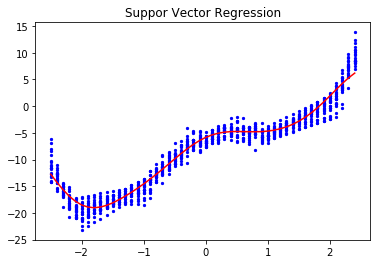

In [120]:
modelSVR = svm.SVR(kernel = 'rbf')
modelSVR.fit(X1D, Y.reshape(len(Y[0, :]) * sweeps))
y_svr = modelSVR.predict(x.reshape(-1, 1))

plt.scatter(X1D, Y1D, s = 5, c = 'b')
plt.plot(x, y_svr, 'r')
plt.title('Suppor Vector Regression')
plt.show()

In [121]:
p = np.polyfit(x, y_svr, 3) 
f = polygen(p)
Y1D_svr_poly = np.array(list(map(f, x)))